## Luminosity comparison

In [4]:
from import_data import HMXB_parameters_Kaper
from import_data import HMXB_parameters
from import_data import supergiant_stellar_parameters
from import_data import falenga
from functions import scientific_notation
from import_data import stellar_params
from import_data import photometric_params

from astropy.constants import R_sun, L_sun, sigma_sb

import pandas as pd
import dataframe_image as dfi
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2E' % x)

In [5]:
# Import data
df_hmxb = HMXB_parameters()
df_sg_params = supergiant_stellar_parameters()
df_falenga = falenga()
df_stellar_params = stellar_params()
df_photometric_params = photometric_params()

df_luminosity = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "L_phot": [None] * len(df_hmxb['id']),
                              "L_bol": [None] * len(df_hmxb['id'])})

### Calculate the luminosity from photometric data

In [6]:
for i in range(df_hmxb.shape[0]):
    # Spectral type of object
    spectral_type = df_hmxb.loc[i, "spectraltype(short)"]
    # Expected (B-V) of object based on spectral type
    BV0 = df_sg_params[df_sg_params['sp'] == spectral_type]["(B-V)0"].reset_index(drop=True).at[0]
    # Observed (B-V) of object based on simbad filters
    BVobs = df_hmxb.loc[i, '(B-V)obs']
    # Bolometric correction (BC)
    BC = df_sg_params[df_sg_params['sp'] == spectral_type]["BC"].reset_index(drop=True).at[0]

    # Calculate extinction
    Av = 3.2 * (BVobs - BV0)

    # Calculate Absulute magnitude (visual)
    Mv = df_hmxb.loc[i, 'mv'] - 5 * np.log10(df_hmxb.loc[i, 'distance'] * 1000) + 5 - Av

    # Calculate bolomatric absolute magnitude
    Mbol = Mv + BC

    # Calculate the luminosity in solar luminosities
    L = 10**((Mbol - 4.74) / (-2.5))

    # Put L in luminosity dataframe
    df_luminosity.loc[df_luminosity["id"] == df_hmxb.loc[i, 'id'], "L_phot"] = L
    # Put L in the dataframe
    df_hmxb.loc[i, 'luminosity'] = L


In [7]:
for i in range(df_hmxb.shape[0]):
    # Calculate extinction
    Av = 3.2 * (df_hmxb.loc[i, '(B-V)obs'] - df_hmxb.loc[i, '(B-V)0'])

    # Calculate Absulute magnitude (visual)
    Mv = df_hmxb.loc[i, 'mv'] - 5 * np.log10(df_hmxb.loc[i, 'distance'] * 1000) + 5 - Av

    # Calculate bolomatric absolute magnitude
    Mbol = Mv + df_hmxb.loc[i, 'BC']

    # Calculate the luminosity in solar luminosities
    L = 10**((Mbol - 4.74) / (-2.5))

    # Put L in luminosity dataframe
    df_luminosity.loc[df_luminosity["id"] == df_hmxb.loc[i, 'id'], "L_phot"] = L
    # Put L in the dataframe
    df_hmxb.loc[i, 'luminosity'] = L

### Caclulate the luminosity from the radius and temperature of the optical star

In [8]:
for i in range(df_falenga.shape[0]):
    # Orbital separation
    a = df_falenga.loc[i, 'a'] * R_sun.value
    # Inclination
    inc = df_falenga.loc[i, 'i']
    # Semi eclipse angle
    theta_e = df_falenga.loc[i, 'semi_eclipse_angle']


    # Calculate Radius
    Rob = a * ((np.cos(np.deg2rad(inc)))**2 + (np.sin(np.deg2rad(inc)))**2 * (np.sin(np.deg2rad(theta_e)))**2)**(1/2)

    # Object id
    id = df_falenga.loc[i, 'id']
    # Spectral type
    spectral_type = df_hmxb[df_hmxb["id"] == str(id)]["spectraltype(short)"].reset_index(drop=True).at[0]
    # Spectral temperature
    logTeff = df_sg_params[df_sg_params["sp"] == spectral_type]["logTeff"].reset_index(drop=True).at[0]
    Teff = 10**logTeff

    # Calculate Luminosity in solar luminosities
    L = (4 * np.pi * Rob**2 * sigma_sb.value * Teff**4) / L_sun.value

    # Put L in luminosity dataframe
    df_luminosity.loc[df_luminosity["id"] == id, "L_bol"] = L

### Make plots

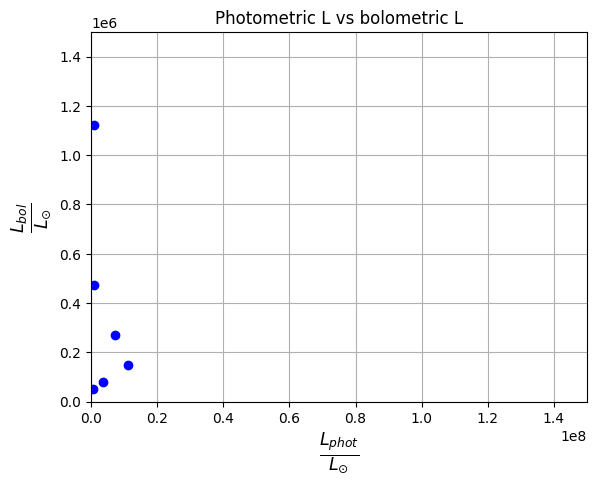

In [9]:
filtered_df = df_luminosity.dropna(subset=["L_phot", "L_bol"])

# Create a scatter plot of L1 vs. L2
plt.scatter(filtered_df["L_phot"], filtered_df["L_bol"], color='blue')
plt.grid(True)
plt.xlabel(r"$\frac{L_{phot}}{L_{\odot}}$", fontsize=18)
plt.ylabel(r"$\frac{L_{bol}}{L_{\odot}}$", fontsize=18)
plt.xlim(0, 1.5 * 10**8)
plt.ylim(0, 1.5 * 10**6)
plt.title("Photometric L vs bolometric L")
plt.savefig("/mnt/c/Users/luukv/OneDrive/Masterproject/plots/UnderluminousScatter.png")
plt.show()

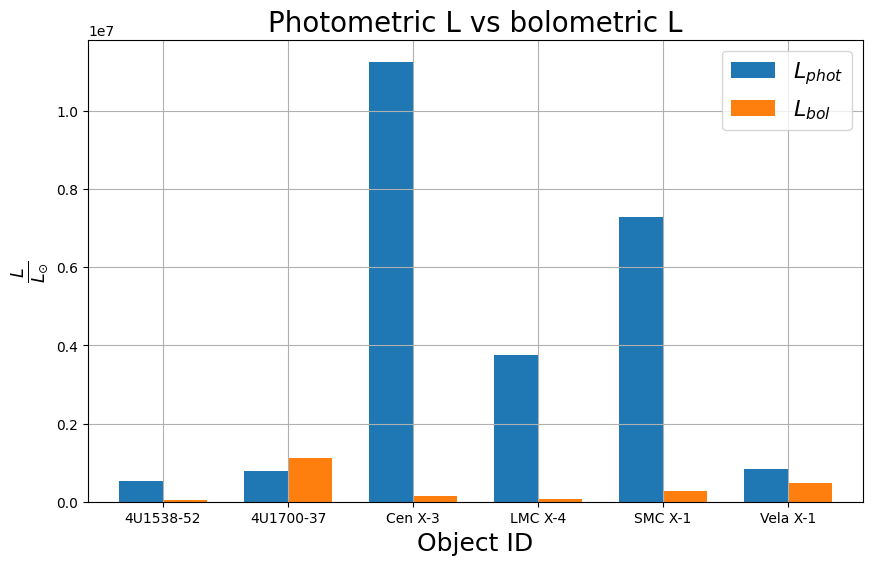

In [10]:
# Group the DataFrame by "id" and calculate the sum of "L1" and "L2" for each group
grouped = filtered_df.groupby("id")[["L_phot", "L_bol"]].sum()

# Plot the bar chart
grouped.plot(kind="bar", width=0.7, figsize=(10, 6))
plt.grid(True)
plt.xlabel("Object ID", fontsize=18)
plt.ylabel(r"$\frac{L}{L_{\odot}}$", fontsize=18)
plt.title("Photometric L vs bolometric L", fontsize=20)
plt.legend([r"$L_{phot}$", r"$L_{bol}$"], fontsize=16)
plt.xticks(rotation=0)  # Optional: Rotate x-axis labels if needed
plt.savefig("/mnt/c/Users/luukv/OneDrive/Masterproject/plots/UnderluminousBar.png")
plt.show()

Calculate $\frac{L_{phot}}{L_{bol}}$ (all luminosities are in solar units)

In [11]:
# Filter out all rows with none values
df_luminosity_filtered = df_luminosity.copy().dropna()
df_luminosity_filtered.reset_index(drop=True)
df_luminosity_filtered["L_phot/L_bol"] = df_luminosity_filtered["L_phot"] / df_luminosity_filtered["L_bol"]
df_luminosity_filtered

,id,L_phot,L_bol,L_phot/L_bol
1,SMC X-1,7.30E+06,2.68E+05,2.72E+01
2,LMC X-4,3.77E+06,7.91E+04,4.76E+01
3,Vela X-1,8.50E+05,4.72E+05,1.80E+00
4,Cen X-3,1.13E+07,1.49E+05,7.58E+01
6,4U1538-52,5.23E+05,5.21E+04,1.00E+01
7,4U1700-37,7.75E+05,1.12E+06,6.92E-01


In [12]:
df_hmxb.style

,id,spectraltype,spectraltype(short),ruwe,period,spinperiod,eclipseduration,RV,Mob,Rob,Mx,parallax,errparallax,distance,distanceBJ,luminosity,(B-V)obs,B,V,(B-V)0,BC,mv,Teff
0,2S0114+650,B1Iae,B1,0.944642,15.660000,10008.000000,nan,-80.000000,16.000000,nan,nan,0.196417,0.011268,5.091205,nan,49208.616723,0.850000,11.990000,11.140000,-0.280000,-0.980000,11.140000,25119
1,SMC X-1,O9.7Ia+,O9,1.002890,nan,nan,nan,nan,nan,nan,nan,0.003992,0.024795,250.514135,nan,7299018.611203,-0.150000,13.000000,13.150000,-0.320000,-3.030000,13.150000,32211
2,LMC X-4,O8III,O8,1.014480,1.400000,13.500000,nan,nan,nan,nan,nan,0.004435,0.021808,225.469097,nan,3765078.649906,-0.100000,13.900000,14.000000,-0.320000,-3.230000,14.000000,33963
3,Vela X-1,B0.5Ia,B0,0.880197,0.000896,283.000000,nan,-3.200000,26.000000,nan,nan,0.496240,0.015161,2.015154,nan,849995.209055,0.500000,7.370000,6.870000,-0.310000,-2.840000,6.870000,29512
4,Cen X-3,O9III,O9,1.020704,2.030000,0.000048,nan,32.000000,20.200000,nan,nan,0.138719,0.013698,7.208805,nan,11264879.332612,2.130000,14.400000,12.270000,-0.320000,-3.030000,12.270000,32211
5,GX301-2,B1.5Iaeq,B1,0.908531,0.041500,680.000000,nan,4.100000,43.000000,nan,nan,0.250621,0.015990,3.990086,nan,1568789.081906,2.040000,12.700000,10.660000,-0.280000,-0.980000,10.660000,25119
6,4U1538-52,B0.2Ia,B0,0.985791,0.000037,526.420000,nan,-158.000000,20.000000,nan,nan,0.127959,0.015252,7.814976,nan,523184.997756,1.800000,16.300000,14.500000,-0.310000,-2.840000,14.500000,29512
7,4U1700-37,O6Iafcp,O6,0.808192,0.000003,nan,nan,-60.000000,46.000000,nan,nan,0.632736,0.025949,1.580438,nan,775452.321506,0.270000,6.780000,6.510000,-0.330000,-3.580000,6.510000,38282
8,4U1907+09,O8.5Iab,O8,0.883853,0.000838,437.500000,nan,nan,27.800000,nan,nan,0.232628,0.073137,4.298703,nan,1742107.551680,3.060000,19.410000,16.350000,-0.320000,-3.230000,16.350000,33963
9,LMC X-1,O8(f)p,O8,0.996263,3.909170,nan,nan,nan,31.790000,nan,nan,0.027471,0.017702,36.402117,nan,201304.410650,0.300000,14.800000,14.500000,-0.320000,-3.230000,14.500000,33963
